# Imports

In [1]:
import os
import re
import cv2
import time
import ffmpeg
import tarfile
import requests
import numpy as np
import pandas as pd
import networkx as nx
import ringity as rng
import seaborn as sns
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import xml.etree.ElementTree as ET

from zipfile import ZipFile
from collections import Counter
from pathlib import Path
from itertools import combinations, product as iter_product
from skimage.metrics import mean_squared_error as mse
from scipy.spatial.distance import pdist, squareform

rng.set_theme()
DATA_DIR = Path("..") / "data"

# Lipid co-regulation network

## Download data

### paths and URLs

In [2]:
LIPID_FOLDER = DATA_DIR / "lipid_network"
LIPID_URL    = "https://ars.els-cdn.com/content/image/1-s2.0-S0092867415006418-mmc3.xlsx"
LIPID_EXCEL_FILE = LIPID_FOLDER / "1-s2.0-S0092867415006418-mmc3.xlsx"
LIPID_CORR_FILE = LIPID_FOLDER / "lipid_corr.txt"

### download data

In [3]:
if not os.path.exists(LIPID_FOLDER):
    os.makedirs(LIPID_FOLDER)

r = requests.get(LIPID_URL, allow_redirects=True)
with open(LIPID_EXCEL_FILE, 'wb') as f:
    f.write(r.content)

## Analysis

### calculate correlations

In [4]:
skiprows = [168]           # No data for C20 Sphingomyelin available

genes = ['sh:Sptlc2', 'sh:CerS2', 'sh:CerS6' , 
         'sh:Smpd1' , 'sh:Asah1', 'sh:Ugcg'  , 
         'sh:CLN3'  , 'sh:Lyst' , 'sh:Ormdl1', 
        #'sh:GFP'        #(green fluorescent protein) used to normalize data
         ]

lipid_excel_df = pd.read_excel(LIPID_EXCEL_FILE, 
                   header    = 1, 
                   index_col = 0,
                   skiprows = skiprows
                  )[genes]

lipid_corr_df = lipid_excel_df.T.corr()

### define thresholded network

In [5]:
c = 0.6   # threshold

# create (binary) network 
G_lipid = nx.from_pandas_adjacency(lipid_corr_df.abs() > c)
G_lipid.remove_edges_from(nx.selfloop_edges(nx.Graph(G_lipid)))
# get lcc
G_lipid = G_lipid.subgraph(max(nx.connected_components(G_lipid), key=len)) 
    
pos = nx.spring_layout(G_lipid)

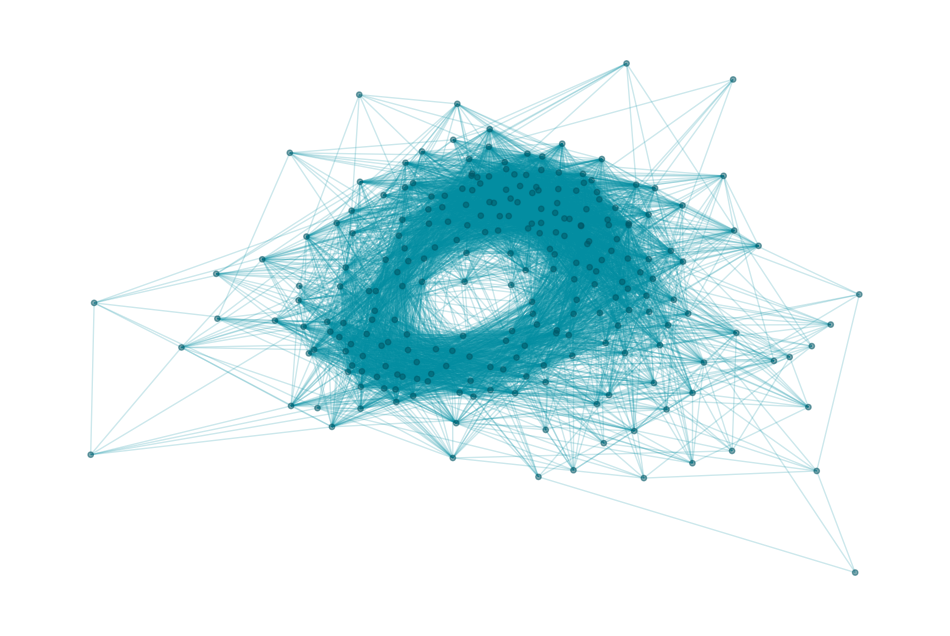

In [6]:
rng.plot_nx(G_lipid, pos=pos, node_alpha=0.5)

### degree distribution

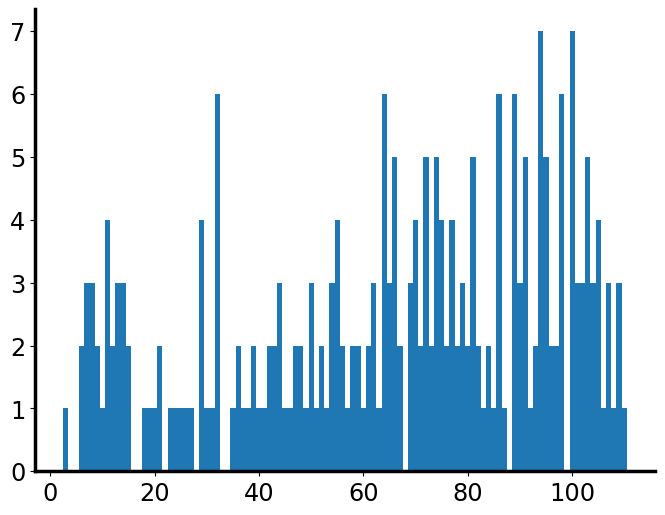

In [7]:
degree_sequence = sorted([d for n, d in G_lipid.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

bars = ax.bar(degs, cnts, width=1)

### persistence diagrams

In [8]:
D_lipid   = (1-lipid_corr_df.abs()).values              # calculate distance matrix
dgm_lipid = rng.pdiagram(D_lipid, distance_matrix=True)
dgm_lipid_c = rng.pdiagram(G_lipid.copy())

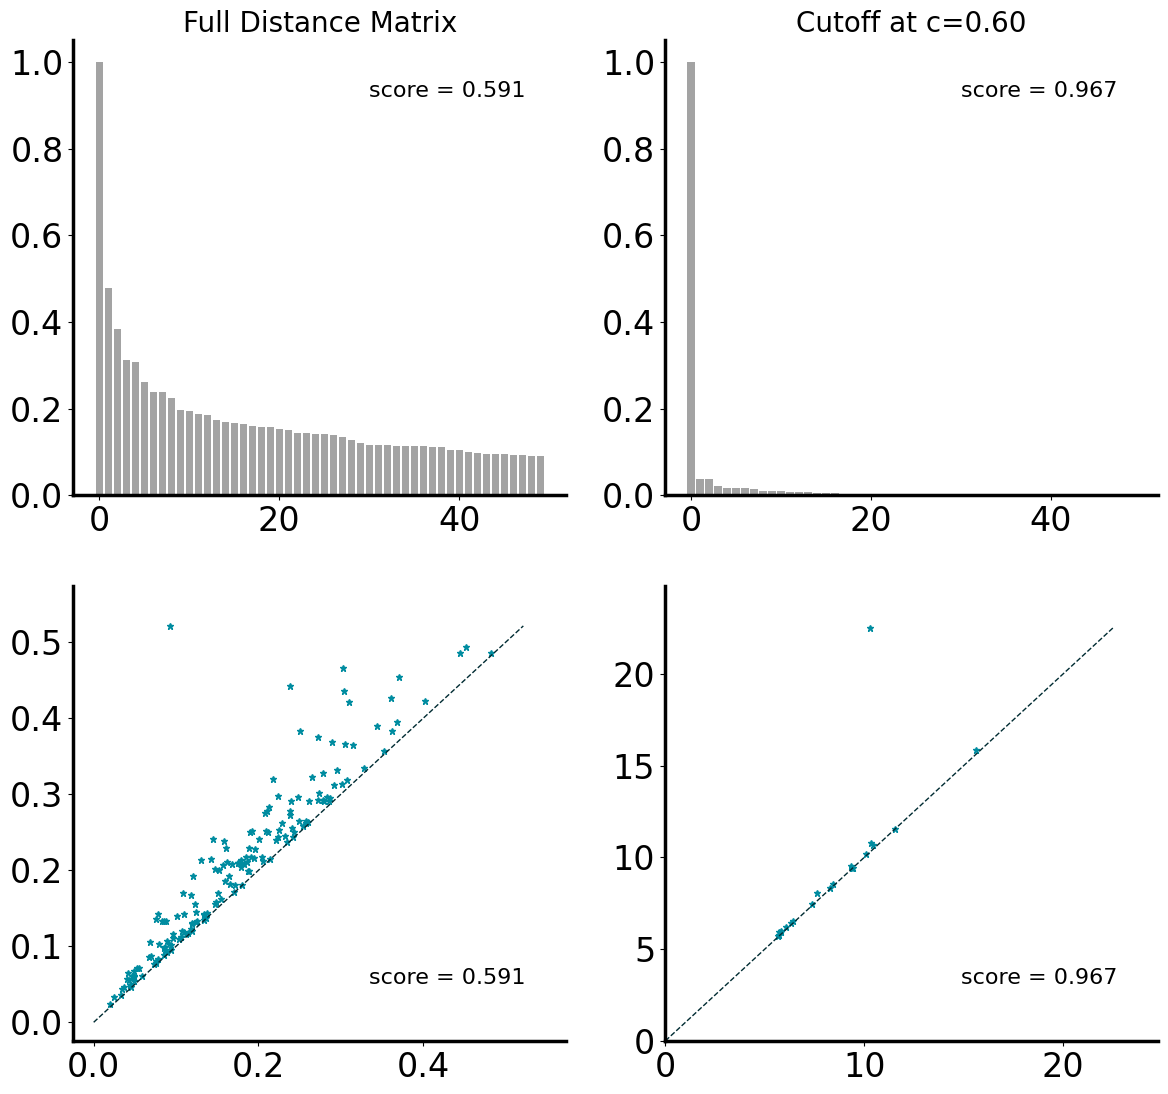

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14,13))

axes[0,0].set_title('Full Distance Matrix', fontsize=20)
axes[0,1].set_title(f'Cutoff at c={c:.2f}', fontsize=20)

rng.plot_seq(dgm_lipid,   ax=axes[0,0], trim=50)
rng.plot_seq(dgm_lipid_c, ax=axes[0,1], trim=50)
rng.plot_dgm(dgm_lipid,   ax=axes[1,0])
rng.plot_dgm(dgm_lipid_c, ax=axes[1,1])

for nr, (ypos, pdgm) in enumerate(iter_product([0.875, 0.125], [dgm_lipid, dgm_lipid_c])):
    anno = axes.flatten()[nr].annotate(f'score = {pdgm.ring_score():.3f}', 
                                       xy=(0.6, ypos), 
                                       xycoords='axes fraction', 
                                       fontsize=16)

# Fibroblast proximity network

## Analysis

### paths

In [10]:
FIBRO_FOLDER = DATA_DIR / "fibroblast_network"
FIBRO_FILE   = FIBRO_FOLDER / "connectivity_FLS11_data.xls"

name = "FLS18 TNF"

### define thresholded network

In [11]:
d = 115    # threshold

fibro_position_df = pd.read_excel(FIBRO_FILE, sheet_name=name)
# distance matrix
D_fibro = squareform(pdist(fibro_position_df[['Position X','Position Y','Position Z']]))

# create (unweighted) network 
G_fibro = nx.from_numpy_array(np.where(D_fibro > d,0,1))
G_fibro.remove_edges_from(nx.selfloop_edges(nx.Graph(G_fibro)))

# get lcc, in case threshold was chosen too low
G_fibro = G_fibro.subgraph(
            max(nx.connected_components(G_fibro), key=len)).copy()
    
pos = nx.spring_layout(G_fibro)

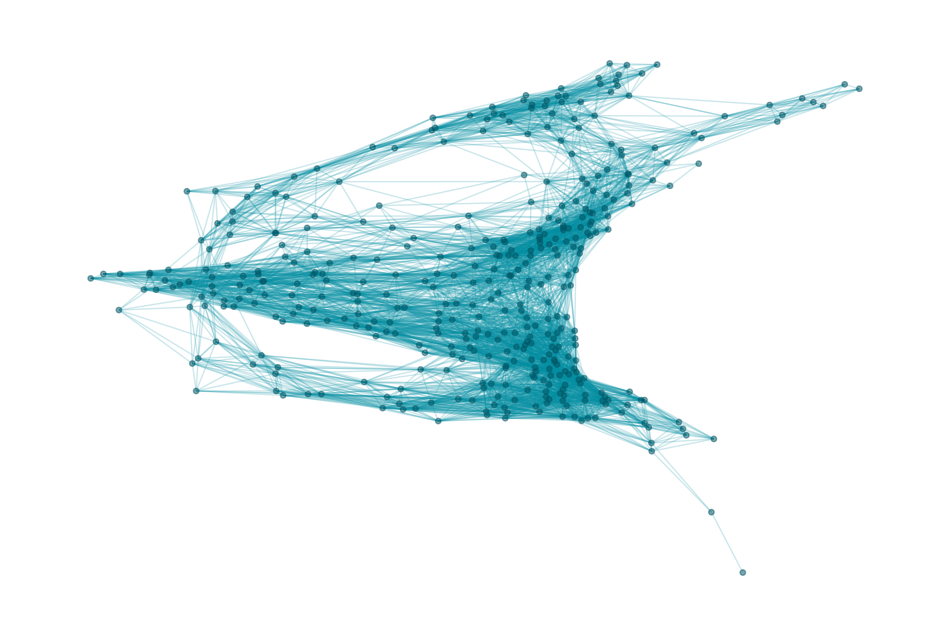

In [12]:
rng.plot_nx(G_fibro, pos=pos, node_alpha=0.5)

### degree distribution

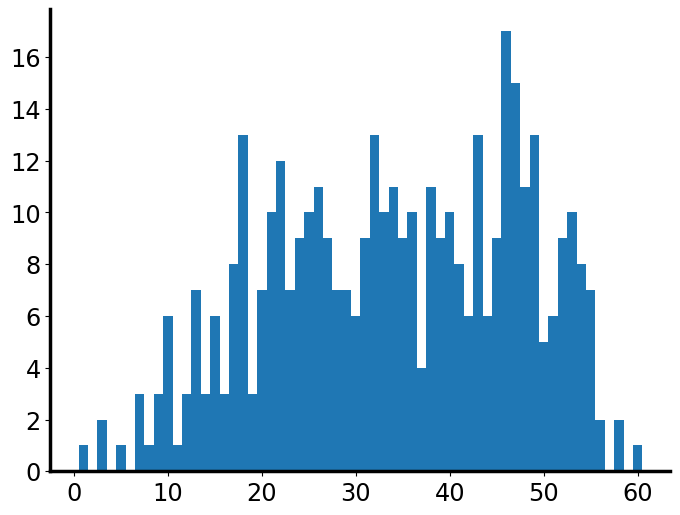

In [13]:
degree_sequence = sorted([d for n, d in G_fibro.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

bar = ax.bar(degs, cnts, width=1)

### persistence diagrams

In [14]:
dgm_fibro = rng.pdiagram(D_fibro, distance_matrix=True)
dgm_fibro_d = rng.pdiagram(G_fibro)

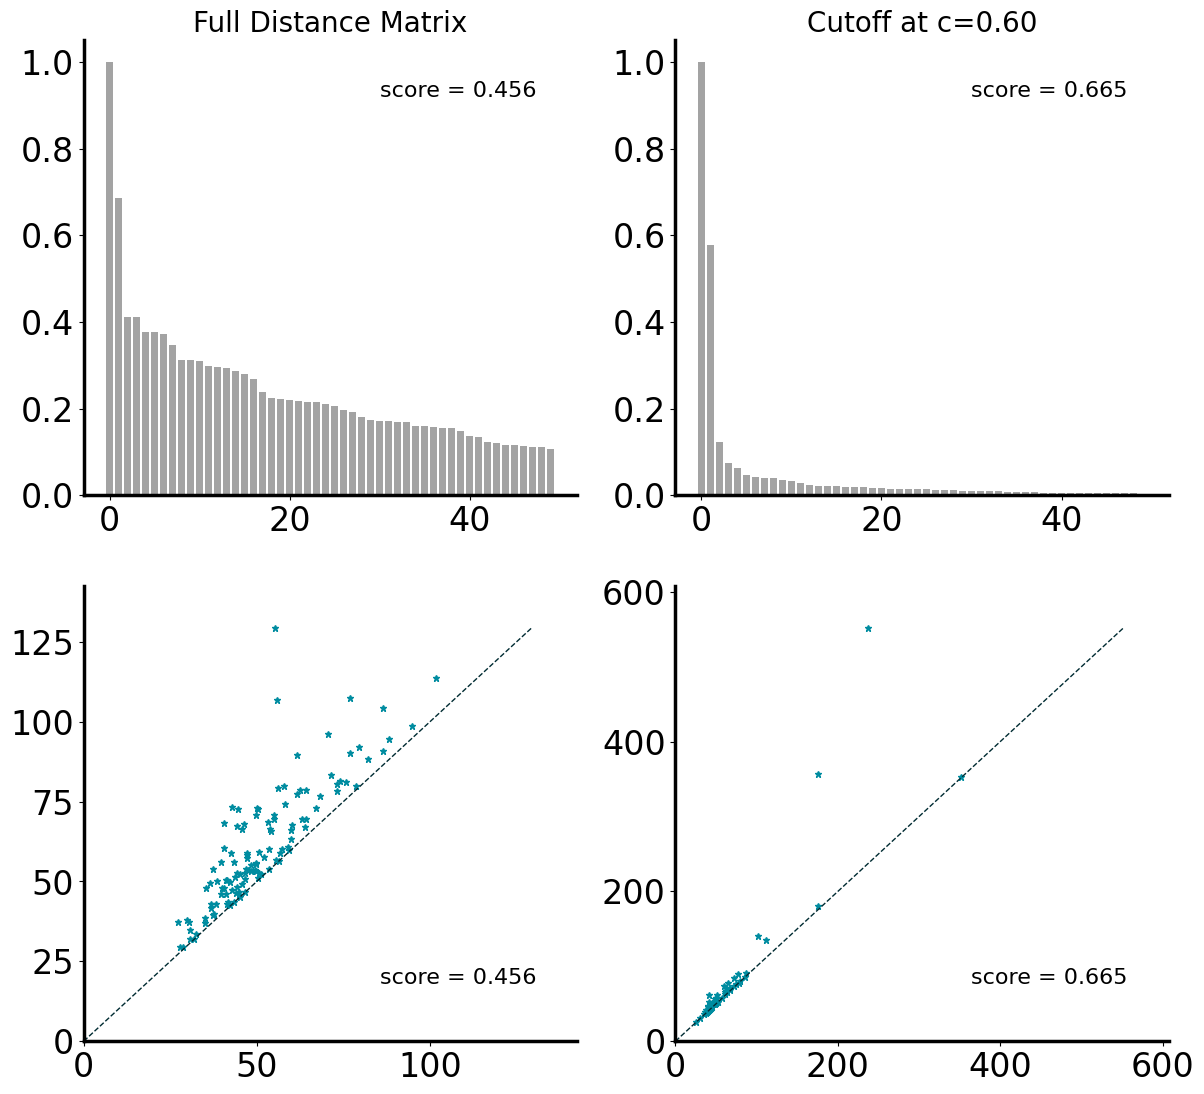

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(14,13))

axes[0,0].set_title('Full Distance Matrix', fontsize=20)
axes[0,1].set_title(f'Cutoff at c={c:.2f}', fontsize=20)

rng.plot_seq(dgm_fibro,   ax=axes[0,0], trim=50)
rng.plot_seq(dgm_fibro_d, ax=axes[0,1], trim=50)
rng.plot_dgm(dgm_fibro,   ax=axes[1,0])
rng.plot_dgm(dgm_fibro_d, ax=axes[1,1])

for nr, (ypos, pdgm) in enumerate(iter_product([0.875, 0.125], [dgm_fibro, dgm_fibro_d])):
    anno = axes.flatten()[nr].annotate(f'score = {pdgm.ring_score():.3f}', 
                                       xy=(0.6, ypos), 
                                       xycoords='axes fraction', 
                                       fontsize=16)

# Reactome networks

## Download and filter

### Paths and URLs

In [16]:
IMMUNE_FOLDER = DATA_DIR / "immune_network"
IMMUNE_FILE   = IMMUNE_FOLDER / "reactome_smbl.tgz"
IMMUNE_URL    = "https://reactome.org/download/current/homo_sapiens.3.1.sbml.tgz"

ROOT_DIR = IMMUNE_FOLDER / "homo_sapiens"

### download data

In [17]:
if not os.path.exists(IMMUNE_FOLDER):
    os.makedirs(IMMUNE_FOLDER)

# Download all human reactions from Reactome in SBML format
urllib.request.urlretrieve(IMMUNE_URL, IMMUNE_FILE)
tar = tarfile.open(IMMUNE_FILE)
tar.extractall(ROOT_DIR)
tar.close()

### choose parameters to filter databank

In [18]:
ringy_threshold = 0.6
min_nodes = 100

### extract ringy Reactome pathways

In [19]:
ringiy_graph_list = []
namespace = "{http://www.sbml.org/sbml/level3/version1/core}"

for nr, pathway_file in enumerate(os.listdir(ROOT_DIR), 1):
    print(f"{100*nr/len(os.listdir(ROOT_DIR)):.2f}%", end='\r')
    
    sbml = ET.parse(ROOT_DIR / pathway_file)

    model = sbml.getroot().find(namespace + "model")
    reactions =      model.find(namespace + "listOfReactions")

    # List species annotated as "simple chemical" to remove them from networks, 
    # to avoid creating star structures with the most common small molecules
    small_molecs = {term.attrib['id'] for term in model.find(namespace + "listOfSpecies") 
                          if term.attrib.get('sboTerm') == "SBO:0000247"}
    
    pathway_name = model.attrib['name']
    pathway_ID   = model.attrib['id']
    
    # Create directed graph here
    G = nx.Graph(name=model.attrib['name'],
                 id=model.attrib['id']) 
    
    for reaction in reactions:
        
        list_of_products  = reaction.find(namespace + "listOfProducts")
        list_of_reactants = reaction.find(namespace + "listOfReactants")
        
        if (not list_of_products) or (not list_of_reactants):
            continue
        
        products  = {product.attrib['species'] for product in list_of_products
                            if product.attrib['species'] not in small_molecs}
        reactants = {reagent.attrib['species'] for reagent in list_of_reactants
                            if reagent.attrib['species'] not in small_molecs}
            
        # Add edge from reagents to products
        G.add_edges_from((r,p) for (r,p) in iter_product(reactants,products))
    
    if len(G.edges):
        H = G.subgraph(max(nx.connected_components(G), key=len)).copy()
        if len(H) < min_nodes:
            continue
        dgm = rng.pdiagram(H)
        if dgm.ring_score() >= ringy_threshold:
            ringiy_graph_list.append(H)
            print(G.name)
            print('#Nodes in graph: ', len(G))
            print('#Nodes in LCC:   ', len(H))
            print('ring-score:      ', round(dgm.ring_score(),3))
            print()

Interferon Signaling
#Nodes in graph:  248
#Nodes in LCC:    180
ring-score:       0.631

Cellular response to chemical stress
#Nodes in graph:  211
#Nodes in LCC:    166
ring-score:       0.683

Signaling by Nuclear Receptors
#Nodes in graph:  332
#Nodes in LCC:    225
ring-score:       0.714

HCMV Late Events
#Nodes in graph:  114
#Nodes in LCC:    114
ring-score:       0.693

Transcriptional Regulation by MECP2
#Nodes in graph:  120
#Nodes in LCC:    109
ring-score:       1

Diseases of signal transduction by growth factor receptors and second messengers
#Nodes in graph:  575
#Nodes in LCC:    245
ring-score:       0.703

Homology Directed Repair
#Nodes in graph:  115
#Nodes in LCC:    107
ring-score:       0.612

Epigenetic regulation of gene expression
#Nodes in graph:  144
#Nodes in LCC:    105
ring-score:       0.607

Disease
#Nodes in graph:  2298
#Nodes in LCC:    1209
ring-score:       0.72

Adaptive Immune System
#Nodes in graph:  494
#Nodes in LCC:    128
ring-score:       

## Analysis

### choose network to analyse

In [46]:
graph_name = "Interferon Signaling"

G_immune, = [G for G in ringiy_graph_list if G.name == graph_name]
pos = nx.spring_layout(G_immune)

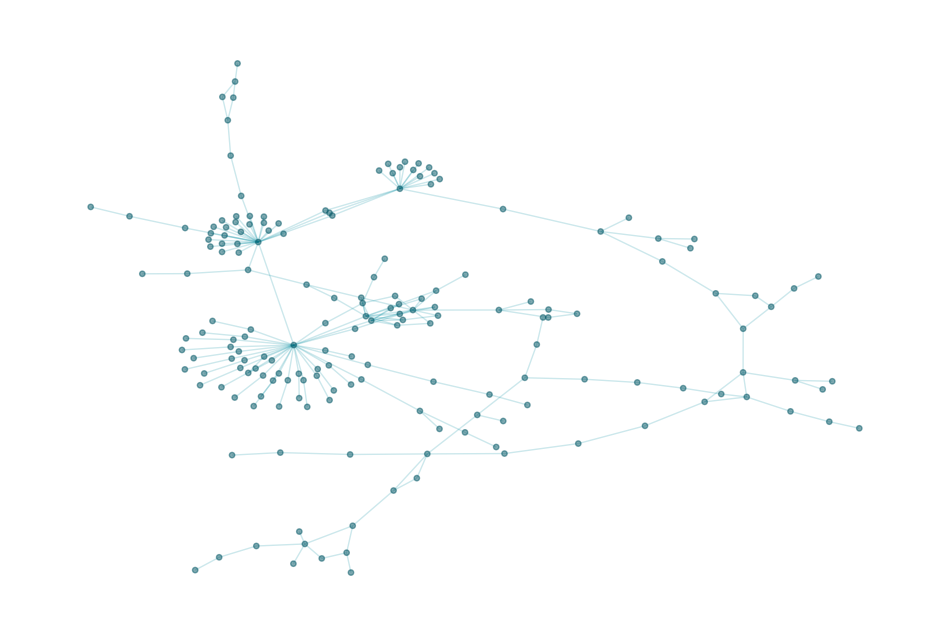

In [47]:
rng.plot_nx(G_immune, pos=pos, node_alpha=0.5)

### degree distribution

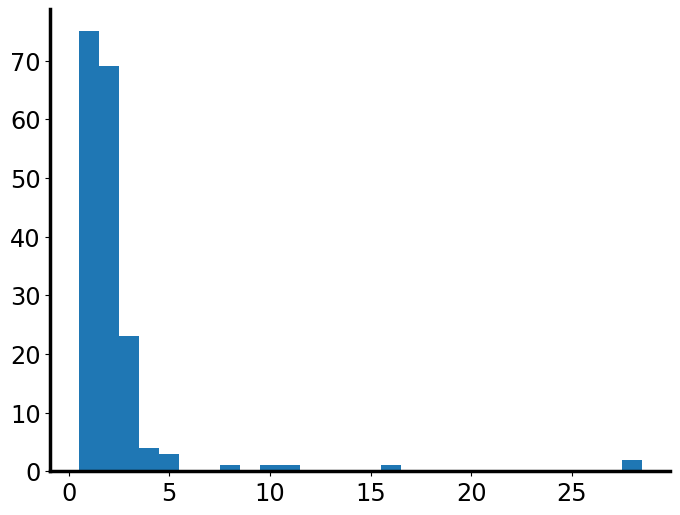

In [48]:
degree_sequence = sorted([d for n, d in G_immune.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

bar = ax.bar(degs, cnts, width=1)

### persistence diagrams

In [49]:
dgm_immune = rng.pdiagram(G_immune)

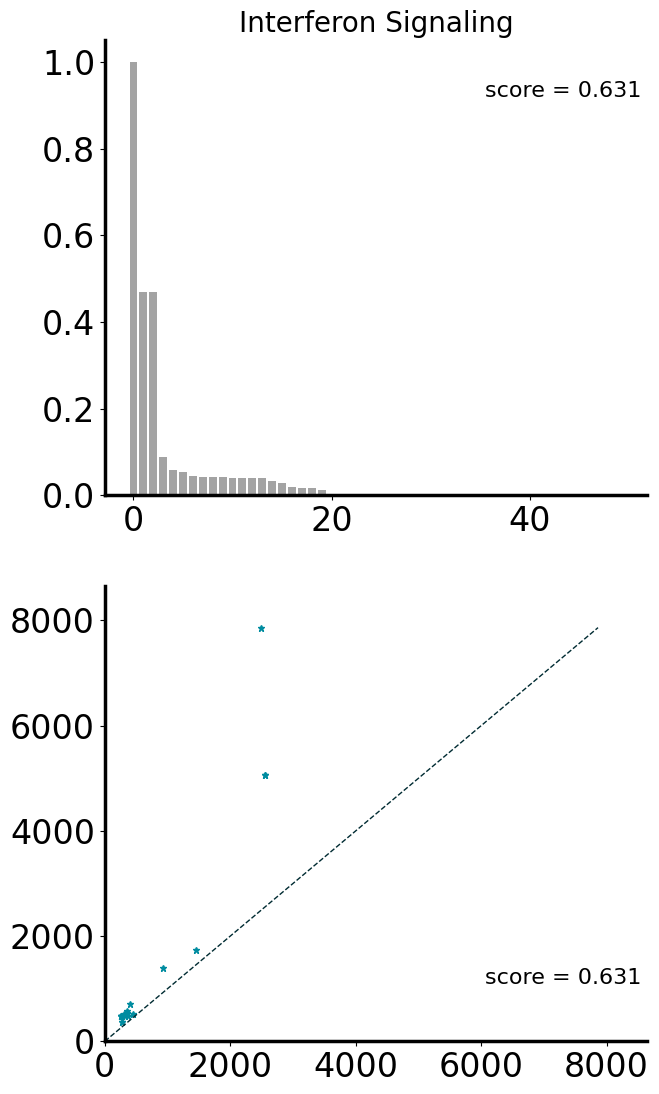

In [50]:
fig, axes = plt.subplots(2, figsize=(7,13))

axes[0].set_title(graph_name, fontsize=20)

rng.plot_seq(dgm_immune, ax=axes[0], trim=50)
rng.plot_dgm(dgm_immune, ax=axes[1])

for nr, ypos in enumerate([0.875, 0.125]):
    anno = axes[nr].annotate(f'score = {dgm_immune.ring_score():.3f}', 
                             xy=(0.7, ypos), 
                             xycoords='axes fraction', 
                             fontsize=16)

## Gene expression network
<center><h3 style="color:darkred"> >>> CAUTION - Big Data! <<<  </h3></center><p>

## download data

### paths and URLs

In [2]:
GENE_FOLDER = DATA_DIR / "gene_network/"
GENE_URL    = "https://www.dropbox.com/s/ms8k4kcga7j4uc0/circadiaNET_correlation_matrices.zip"
GENE_ZIP_FILE = GENE_FOLDER / "circadiaNET_correlation_matrices.zip"

### download data

For some reason this doesn't seem to work properly.   
Please manually download the zip-file from the `GENE_URL` into the `GENE_FOLDER` (after creating it).

In [3]:
if not os.path.exists(GENE_FOLDER):
    os.makedirs(GENE_FOLDER)

# r = requests.get(GENE_URL, allow_redirects=True)
# with open(GENE_ZIP_FILE, 'wb') as f:
#     f.write(r.content)

### unzip data

In [4]:
# In case it is not unziped it already
GENE_FILENAME = Path("circadiaNET_correlation_matrices") / "arabidopsis_thaliana_correlation_matrix.txt"
# with ZipFile(GENE_ZIP_FILE, 'r') as z:
#     z.extract(GENE_FILENAME, GENE_FOLDER)

## Analysis

### define thresholded network

In [9]:
gene_corr_df = pd.read_csv(GENE_FOLDER / GENE_FILENAME, delimiter=' ')

In [26]:
c = 0.9

A = np.where(gene_corr_df.abs() > c, 1, 0)
np.fill_diagonal(A, 0)
2* A.sum() / (len(A) * (len(A)-1))

0.2063368744772839

In [29]:
len(A)

7639

In [28]:
A.sum() / 2

3009768.0

In [14]:
c = 0.9

# get unweighted network
gene_corr_df = pd.read_csv(GENE_FOLDER / GENE_FILENAME, delimiter=' ')
G_gene = nx.from_numpy_array(np.where(gene_corr_df.abs() > c, 1, 0))
G_gene.remove_edges_from(nx.selfloop_edges(nx.Graph(G_gene)))

# # get LCC
# G_gene = G_gene.subgraph(max(nx.connected_components(G_gene), key=len))
# G_gene = nx.convert_node_labels_to_integers(G_gene)

# pos = nx.spring_layout(G_gene)

In [17]:
nx.density(G_gene)

0.10316843723864196

In [16]:
nx.number_of_edges(G_gene)

3009768

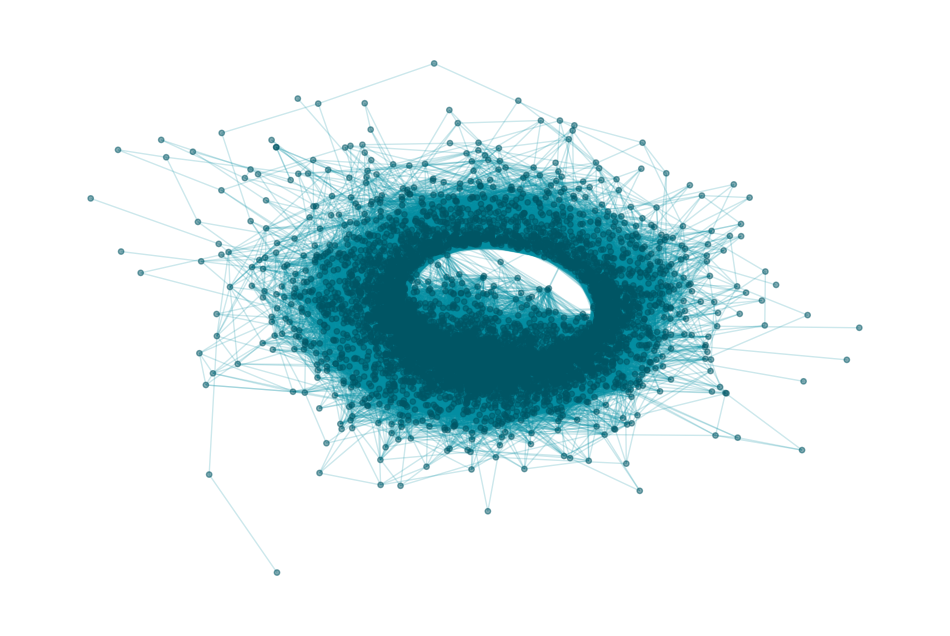

In [6]:
rng.plot_nx(G_gene, pos=pos, node_alpha=0.5)

### degree distribution

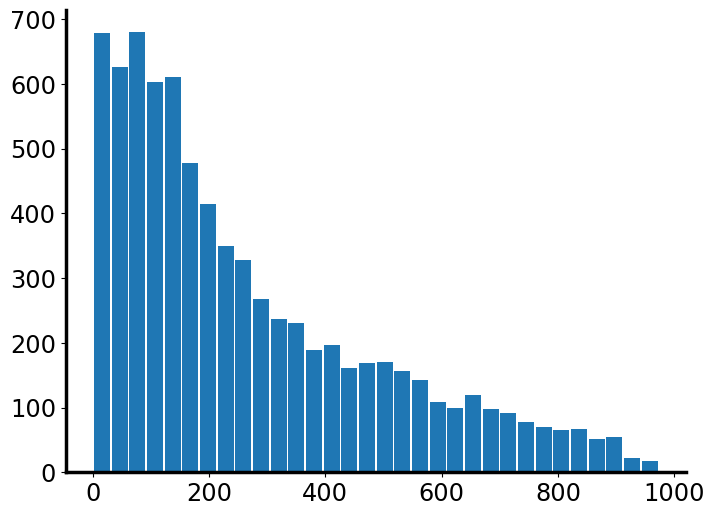

In [7]:
degree_sequence = sorted([d for n, d in G_gene.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))

bar = ax.hist(degree_sequence, bins = 2**5, rwidth=0.9)

### persistence diagram

You might not be able to calculate this on a regular computer.

In [8]:
D_gene   = (1-gene_corr_df.abs()).values              # calculate distance matrix
dgm_gene = rng.pdiagram(D_gene, distance_matrix=True)
dgm_gene_c = rng.pdiagram(G_gene)

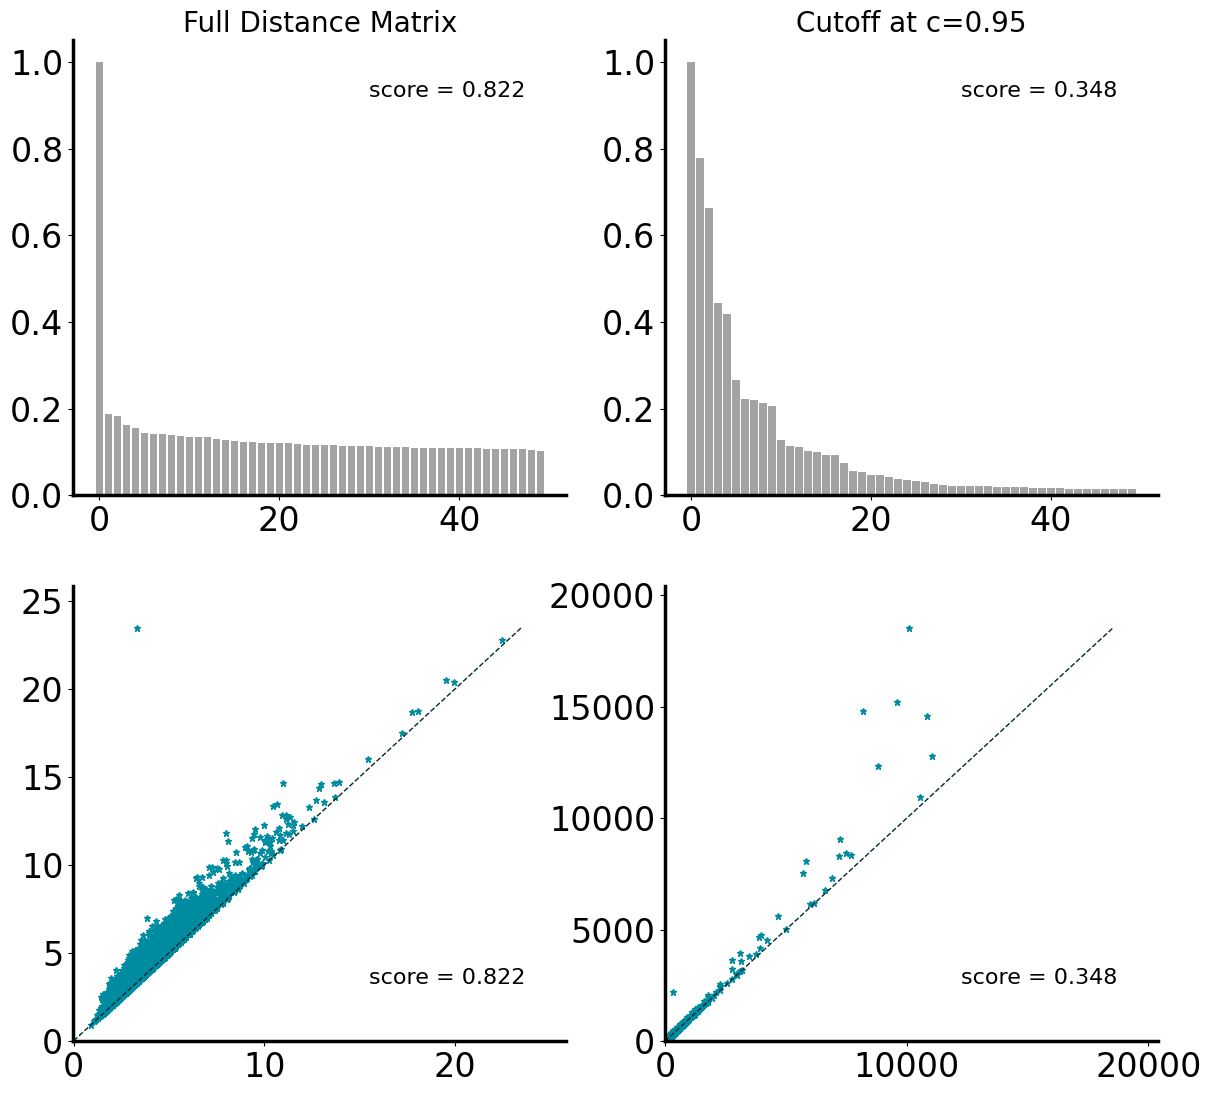

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14,13))

axes[0,0].set_title('Full Distance Matrix', fontsize=20)
axes[0,1].set_title(f'Cutoff at c={c:.2f}', fontsize=20)

rng.plot_seq(dgm_gene,   ax=axes[0,0], trim=50)
rng.plot_seq(dgm_gene_c, ax=axes[0,1], trim=50)
rng.plot_dgm(dgm_gene,   ax=axes[1,0])
rng.plot_dgm(dgm_gene_c, ax=axes[1,1])

for nr, (ypos, pdgm) in enumerate(iter_product([0.875, 0.125], [dgm_gene, dgm_gene_c])):
    anno = axes.flatten()[nr].annotate(f'score = {pdgm.ring_score():.3f}', 
                                       xy=(0.6, ypos), 
                                       xycoords='axes fraction', 
                                       fontsize=16)

# Soil moisture network 

## download data

In [2]:
SOIL_FOLDER = DATA_DIR / "soil_network"
SOIL_URL    = "https://dlmultimedia.esa.int/download/public/videos/2017/11/002/orig-1711_002_AR_EN.mp4"
SOIL_MP4 = SOIL_FOLDER / "orig-1711_002_AR_EN.mp4"

### download data

In [3]:
if not os.path.exists(SOIL_FOLDER):
    os.makedirs(SOIL_FOLDER)

r = requests.get(SOIL_URL, allow_redirects=True)
with open(SOIL_MP4, 'wb') as f:
    f.write(r.content)

### extract frames from video

In [9]:
cap = cv2.VideoCapture(str(SOIL_MP4))
i = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    cv2.imwrite(str(SOIL_FOLDER / f'img{i}.jpg'),frame)
    i+=1

cap.release()
cv2.destroyAllWindows()

## Analysis

### calculate pairwise $\texttt{mse}$

This takes about 5min - coffee time!

In [10]:
pic_list = sorted(file for file in os.listdir(SOIL_FOLDER) if file.endswith('jpg'))

n = len(pic_list)

D_mse  = np.zeros([n,n])

node2img = {}
for jpg in pic_list:
    node_id = int(*re.findall(r'\d+', jpg))
    img = mpimg.imread(f'{SOIL_FOLDER}/{jpg}',0)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    node2img[node_id] = img

t1 = time.time()
for i, (jpg_a, jpg_b) in enumerate(combinations(pic_list, 2)):
    node_a = int(*re.findall(r'\d+', jpg_a))
    node_b = int(*re.findall(r'\d+', jpg_b))

    D_mse[node_a, node_b] = mse(node2img[node_a], node2img[node_b])
    D_mse[node_b, node_a] = D_mse[node_a, node_b]
    
    t2 = time.time()
    print(f'{i/782.1:.3f}% - {t2-t1:.3f}sec', end='\r')

### define thresholded network

In [19]:
d = 90

# get unweighted network
G_soil = nx.from_numpy_array(D_mse < d)
G_soil.remove_edges_from(nx.selfloop_edges(nx.Graph(G_soil)))

# get LCC
G_soil = G_soil.subgraph(max(nx.connected_components(G_soil), key=len))

pos = nx.spring_layout(G_soil)

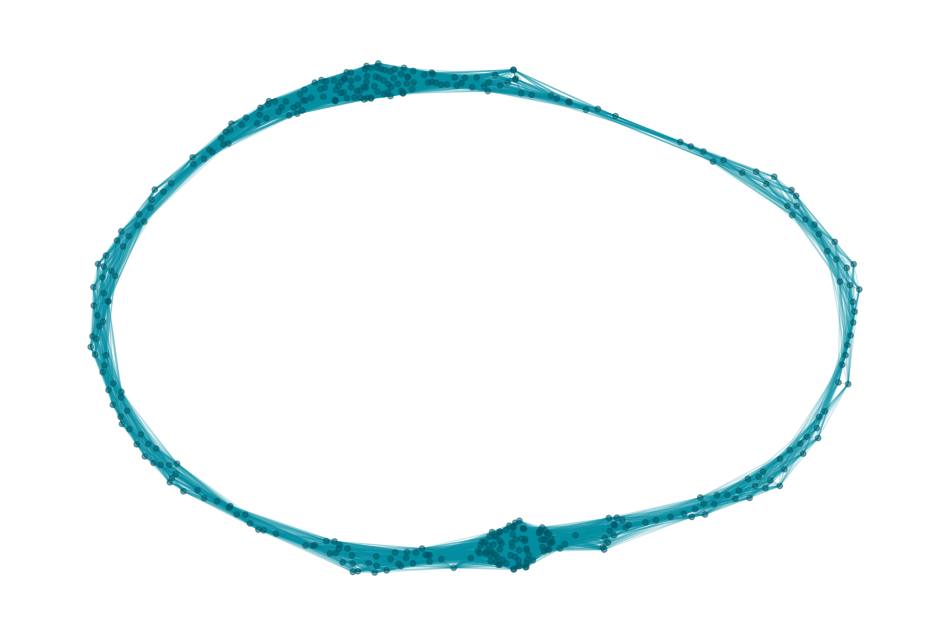

In [20]:
rng.plot_nx(G_soil, pos=pos, node_alpha=0.5)

### degree distribution

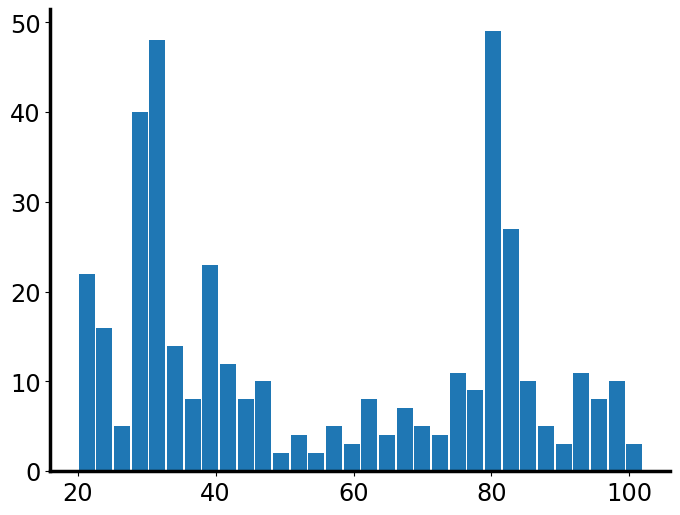

In [24]:
degree_sequence = sorted([d for n, d in G_soil.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))

bar = ax.hist(degree_sequence, bins = 2**5, rwidth=0.9)

### persistence diagrams

In [25]:
dgm_soil = rng.pdiagram(D_mse, distance_matrix=True)
dgm_soil_d = rng.pdiagram(G_soil.copy())

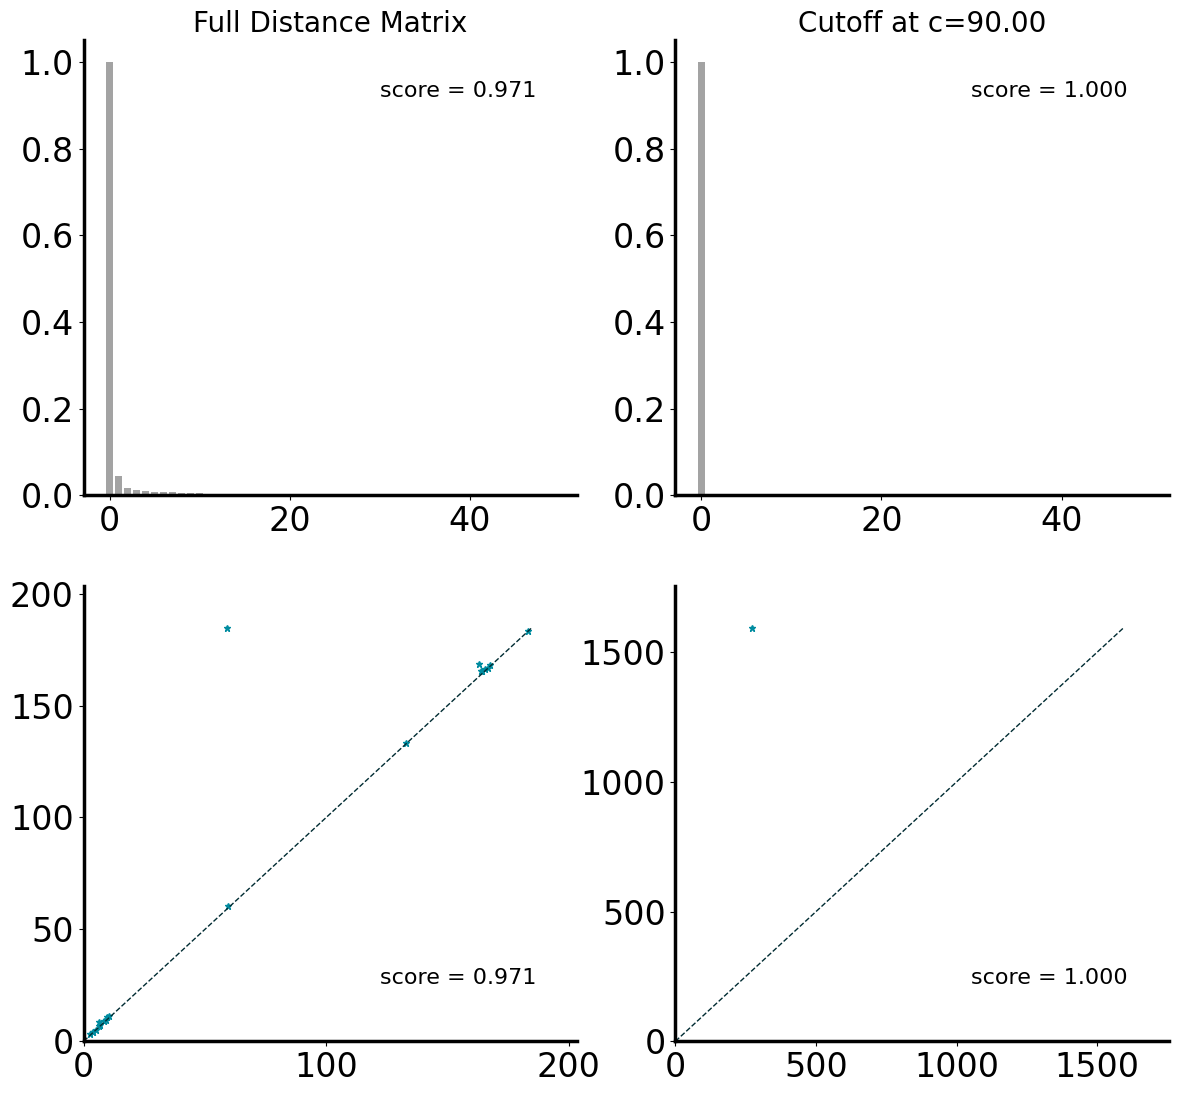

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(14,13))

axes[0,0].set_title('Full Distance Matrix', fontsize=20)
axes[0,1].set_title(f'Cutoff at c={d:.2f}', fontsize=20)

rng.plot_seq(dgm_soil,   ax=axes[0,0], trim=50)
rng.plot_seq(dgm_soil_d, ax=axes[0,1], trim=50)
rng.plot_dgm(dgm_soil,   ax=axes[1,0])
rng.plot_dgm(dgm_soil_d, ax=axes[1,1])

for nr, (ypos, pdgm) in enumerate(iter_product([0.875, 0.125], [dgm_soil, dgm_soil_d])):
    anno = axes.flatten()[nr].annotate(f'score = {pdgm.ring_score():.3f}', 
                                       xy=(0.6, ypos), 
                                       xycoords='axes fraction', 
                                       fontsize=16)

---

# Ego-networks

## Combined networks

### Preparation

In [49]:
# ---------------
# Paths and URLs
# ---------------

EGO_FOLDER = os.getcwd() + "/data/ego_network"
EGO_URL    = "https://snap.stanford.edu/data/facebook_combined.txt.gz"
EGO_EDGELIST_FILE = EGO_FOLDER + "/facebook_combined.txt.gz"

In [50]:
# --------------
# Download data
# --------------

if not os.path.exists(EGO_FOLDER):
    os.makedirs(EGO_FOLDER)

r = requests.get(EGO_URL, allow_redirects=True)
with open(EGO_EDGELIST_FILE, 'wb') as f:
    f.write(r.content)

### Analysis

In [51]:
G_ego = nx.read_edgelist(EGO_EDGELIST_FILE)

pos = nx.spring_layout(G_ego)

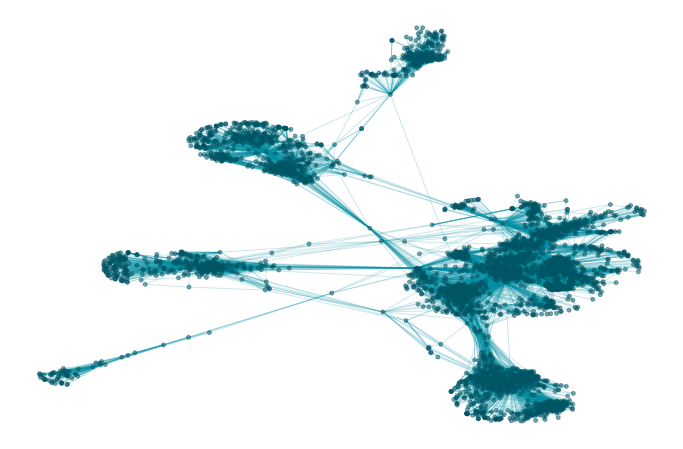

In [48]:
rng.plot_nx(G_ego, pos=pos, node_alpha=0.5)

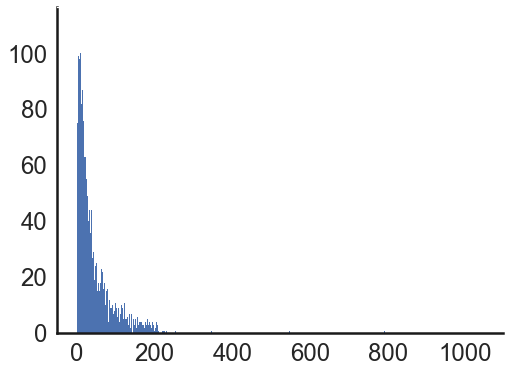

In [55]:
degree_sequence = sorted([d for n, d in G_ego.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.bar(degs, cnts, width=1, linewidth=0);

rng.ax_setup(ax)

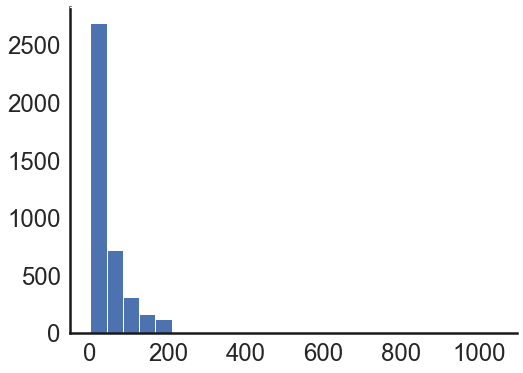

In [57]:
degree_sequence = sorted([d for n, d in G_ego.degree()])

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.hist(degree_sequence, bins=25)

rng.ax_setup(ax)

In [56]:
# ----------------------
# calclulating diagrams
# ----------------------

dgm_ego = rng.diagram(G_ego)

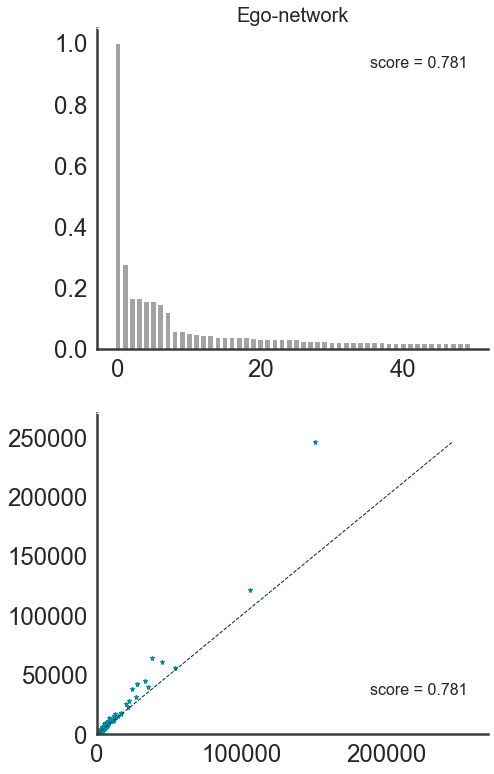

In [59]:
# --------------------
# persistence visuals
# --------------------

fig, axes = plt.subplots(2, figsize=(7,13))

axes[0].set_title("Ego-network", fontsize=20)

rng.plot_bar(dgm_ego, ax=axes[0], cap=50)
rng.plot_dgm(dgm_ego, ax=axes[1])

axes[0].annotate(f'score = {dgm_ego.score  :.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=16);
axes[1].annotate(f'score = {dgm_ego.score  :.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=16);

## Individual networks

### Preparation

In [58]:
# ---------------
# Paths and URLs
# ---------------

EGO_FOLDER = os.getcwd() + "/data/ego_network"
EGO_URL    = "https://snap.stanford.edu/data/facebook.tar.gz"
EGO_TAR = EGO_FOLDER + "/facebook.tar.gz"

In [59]:
# --------------
# Download data
# --------------

if not os.path.exists(EGO_FOLDER):
    os.makedirs(EGO_FOLDER)

r = requests.get(EGO_URL, allow_redirects=True)
with open(EGO_TAR, 'wb') as f:
    f.write(r.content)

tf = tarfile.open(EGO_TAR)
tf.extractall(EGO_FOLDER)

### Analysis

In [60]:
# ---------------
# Set parameters 
# ---------------

min_nodes = 100

In [26]:
# --------------------------------
# Extract ego-networks
# --------------------------------


for file in os.listdir(f"{EGO_FOLDER}/facebook"):
    if not file.endswith('edges'):
        continue
    
    G = nx.read_edgelist(f"{EGO_FOLDER}/facebook/{file}")
    H = nx.induced_subgraph(G, max(nx.connected_components(G), key=len))
    
    if H.number_of_nodes() < min_nodes:
        continue
    
    dgm = rng.diagram(H)
    
    print('ID: ', file.split('.')[0])
    print('#Nodes in graph: ', len(G))
    print('#Nodes in LCC:   ', len(H))
    print('ring-score:      ', round(dgm.score, 3))
    print()

ID:  686
#Nodes in graph:  168
#Nodes in LCC:    168
ring-score:       0.42

ID:  348
#Nodes in graph:  224
#Nodes in LCC:    224
ring-score:       0.661

ID:  3437
#Nodes in graph:  534
#Nodes in LCC:    532
ring-score:       0.142

ID:  1912
#Nodes in graph:  747
#Nodes in LCC:    744
ring-score:       0.224

ID:  1684
#Nodes in graph:  786
#Nodes in LCC:    775
ring-score:       0.174

ID:  0
#Nodes in graph:  333
#Nodes in LCC:    324
ring-score:       0.264

ID:  414
#Nodes in graph:  150
#Nodes in LCC:    148
ring-score:       0.249

ID:  107
#Nodes in graph:  1034
#Nodes in LCC:    1034
ring-score:       0.401



# Foodweb networks

### Preparation

In [61]:
FOODWEB_FOLDER = os.getcwd() + "/data/foodweb_networks"

## Bipartite networks

In [62]:
# ---------------
# Set parameters 
# ---------------

min_nodes = 100

In [6]:
# -------------------------
# Extract foodweb networks
# -------------------------


for file in os.listdir(FOODWEB_FOLDER):
    if not file.endswith('csv') or file == 'references.csv':
        continue
    
 #  Load table 
    foodweb_matrix = pd.read_csv(f"{FOODWEB_FOLDER}/{file}", index_col=0)
    consumers = foodweb_matrix.index
    resources = foodweb_matrix.columns

 #  Construct network
    foodweb_network = nx.Graph()
    foodweb_network.add_nodes_from(consumers)
    foodweb_network.add_nodes_from(resources)
    for con,res in iter_product(consumers, resources):
        if foodweb_matrix.loc[con,res]:
            foodweb_network.add_edge(con,res)
    
    G = foodweb_network
    H = nx.induced_subgraph(G, max(nx.connected_components(G), key=len)).copy()

    if H.number_of_nodes() < min_nodes:
        continue

    dgm = rng.diagram(H)

    print('ID: ', file.split('.')[0])
    print('#Nodes in graph: ', len(G))
    print('#Nodes in LCC:   ', len(H))
    print('ring-score:      ', round(dgm.score, 3))
    print()

ID:  M_PL_044
#Nodes in graph:  719
#Nodes in LCC:    712
ring-score:       0.347

ID:  FW_014_03
#Nodes in graph:  109
#Nodes in LCC:    108
ring-score:       0.019

ID:  M_PL_051
#Nodes in graph:  104
#Nodes in LCC:    104
ring-score:       0.164

ID:  M_PL_053
#Nodes in graph:  393
#Nodes in LCC:    364
ring-score:       0.204

ID:  M_PL_047
#Nodes in graph:  205
#Nodes in LCC:    205
ring-score:       0.025

ID:  M_PL_056
#Nodes in graph:  456
#Nodes in LCC:    456
ring-score:       0.131

ID:  FW_014_04
#Nodes in graph:  113
#Nodes in LCC:    112
ring-score:       0.02

ID:  M_PL_043
#Nodes in graph:  110
#Nodes in LCC:    110
ring-score:       0.106

ID:  M_PL_057
#Nodes in graph:  997
#Nodes in LCC:    997
ring-score:       0.361

ID:  M_PL_055
#Nodes in graph:  259
#Nodes in LCC:    253
ring-score:       0.104

ID:  M_PL_054
#Nodes in graph:  431
#Nodes in LCC:    414
ring-score:       0.335

ID:  FW_011
#Nodes in graph:  105
#Nodes in LCC:    105
ring-score:       0.166

ID:  

### Analysis

In [63]:
foodweb_matrix = pd.read_csv(f"{FOODWEB_FOLDER}/M_SD_034.csv", index_col=0)
consumers = foodweb_matrix.index
resources = foodweb_matrix.columns

#  Construct network
G_food = nx.Graph()
G_food.add_nodes_from(consumers)
G_food.add_nodes_from(resources)
for con,res in iter_product(consumers, resources):
    if foodweb_matrix.loc[con,res]:
        G_food.add_edge(con,res)

pos = nx.spring_layout(G_food)

FileNotFoundError: [Errno 2] File /Users/markusyoussef/Desktop/git/ringity/notebooks/data/foodweb_networks/M_SD_034.csv does not exist: '/Users/markusyoussef/Desktop/git/ringity/notebooks/data/foodweb_networks/M_SD_034.csv'

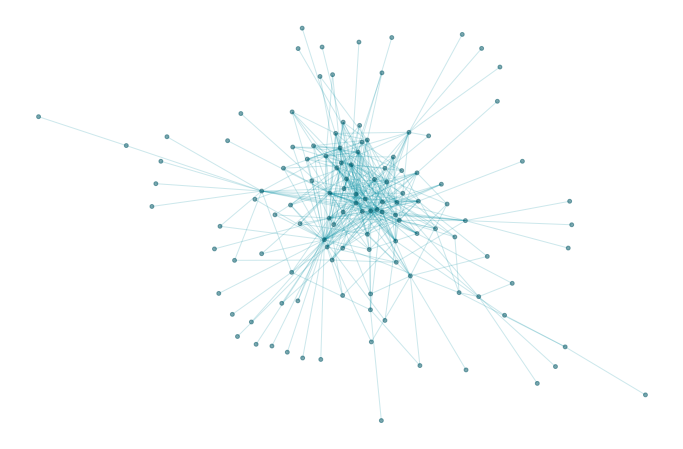

In [11]:
plot_nx(G_food, pos=pos, node_alpha=0.5)

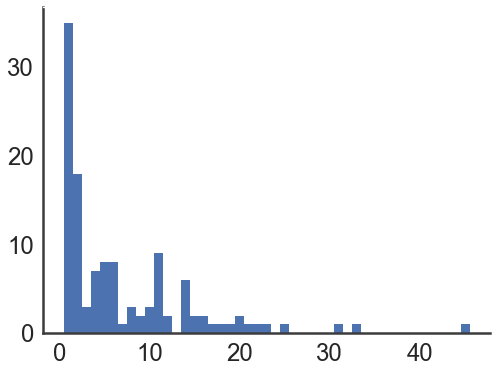

In [13]:
degree_sequence = sorted([d for n, d in G_food.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.bar(degs, cnts, width=1, color=sblue, linewidth=0)

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

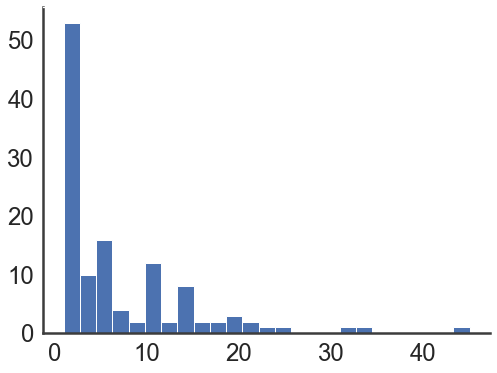

In [16]:
degree_sequence = sorted([d for n, d in G_food.degree()])

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax.hist(degree_sequence, bins=25)

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

plt.savefig("/Users/markusyoussef/Desktop/food_distribution.png")

## Consumer networks

In [52]:
# -------------------------
# Extract foodweb networks
# -------------------------


for file in os.listdir(FOODWEB_FOLDER):
    if not file.endswith('csv') or file == 'references.csv':
        continue
    
 #  Load table 
    foodweb_matrix = pd.read_csv(f"{FOODWEB_FOLDER}/{file}", index_col=0)
    consumers = foodweb_matrix.index

 #  Construct network
    consumer_network = nx.Graph()
    consumer_network.add_nodes_from(consumers)
    
    for con1,con2 in combinations(consumers,2):
        if (foodweb_matrix.loc[con1] + foodweb_matrix.loc[con2]).any():
            consumer_network.add_edge(con1, con2)
    
    G = consumer_network
    H = nx.induced_subgraph(G, max(nx.connected_components(G), key=len)).copy()

    if H.number_of_nodes() < min_nodes or nx.density(H) == 1:
        continue

    dgm = rng.diagram(H)

    print('ID: ', file.split('.')[0])
    print('#Nodes in graph: ', len(G))
    print('#Nodes in LCC:   ', len(H))
    print('ring-score:      ', round(dgm.score, 3))
    print()

ID:  FW_014_03
#Nodes in graph:  109
#Nodes in LCC:    109
ring-score:       0

ID:  FW_014_04
#Nodes in graph:  113
#Nodes in LCC:    113
ring-score:       0

ID:  FW_011
#Nodes in graph:  105
#Nodes in LCC:    105
ring-score:       0

ID:  FW_015_04
#Nodes in graph:  107
#Nodes in LCC:    107
ring-score:       0



## Resources networks

In [55]:
# -------------------------
# Extract foodweb networks
# -------------------------


for file in os.listdir(FOODWEB_FOLDER):
    if not file.endswith('csv') or file == 'references.csv':
        continue
    
 #  Load table 
    foodweb_matrix = pd.read_csv(f"{FOODWEB_FOLDER}/{file}", index_col=0)
    resources = foodweb_matrix.columns

 #  Construct network
    resource_network = nx.Graph()
    resource_network.add_nodes_from(resources)
    
    for res1,res2 in combinations(resources,2):
        if (foodweb_matrix[res1] + foodweb_matrix[res2]).any():
            consumer_network.add_edge(res1, res2)
    
    G = resource_network
    H = nx.induced_subgraph(G, max(nx.connected_components(G), key=len)).copy()

    if H.number_of_nodes() < min_nodes or nx.density(H) == 1:
        continue
    break

    dgm = rng.diagram(H)

    print('ID: ', file.split('.')[0])
    print('#Nodes in graph: ', len(G))
    print('#Nodes in LCC:   ', len(H))
    print('ring-score:      ', round(dgm.score, 3))
    print()

## Genes
<center><h3 style="color:darkred"> >>> CAUTION - Big Data! <<<  </h3></center><p>

*Uncomment lines if the data is not produced yet.*

### Network processing

In [336]:
c = 0.95

# C = np.genfromtxt('data/biological_networks/genes/gene_corr.txt')
# D = 1-np.abs(C)
# A = np.where(np.abs(C)>c,1,0)
# np.fill_diagonal(A,0)
# G = nx.from_numpy_array(A)
# G = max(nx.connected_component_subgraphs(G), key=len)
# G = nx.convert_node_labels_to_integers(G)

# for _, _, data in G.edges(data=True): data.pop('weight',None)
# nx.write_edgelist(G, f'data/biological_networks/genes/gene_c{c:.2f}_edgelist.csv', data=False)

### Network visuals - this might take a while ...    
&nbsp;&nbsp;&nbsp;&nbsp;(~15min on my computer)

*Load network for rerunning the visuals.*

In [337]:
G = nx.read_edgelist(f'data/biological_networks/genes/gene_c{c:.2f}_edgelist.csv', nodetype=int, data=False)

*Precompute/load layout positions.*

In [235]:
# pos = nx.spring_layout(G)
# with open(f'data/biological_networks/genes/gene_c{c:.2f}_pos.pkl', 'wb') as f:
#     pickle.dump(pos, f)

In [64]:
with open(f'data/biological_networks/genes/gene_c{c:.2f}_pos.pkl', 'rb') as f:
    pos = pickle.load(f)

*Plotting the network; this is the most time-consuming step. You might wanna save it right away.*

In [492]:
# pos = comb(pos)      # moves sticky-out edges closer to the center
# plot_nx(G, pos=pos)

*Save plot with precomputed layout positions.*

In [494]:
plot_nx(G, path=f'data/biological_networks/genes/gene_c{c:.2f}_nx.pdf',  silence=True, pos=pos)

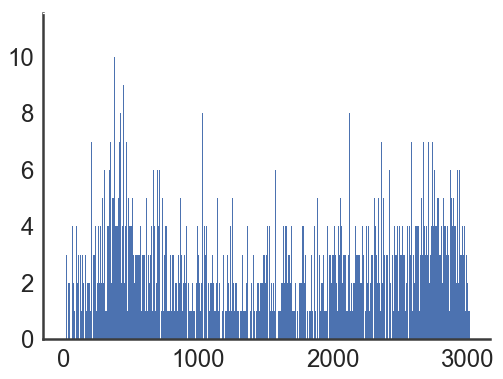

In [343]:
mode = 'bar'

degree_sequence = sorted([d for n, d in G.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

eval(f"ax.{mode}(degs, cnts, width=1, color=sblue, linewidth=0)");

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

deg_fig.savefig(f'google_drive/genes/gene_c{c:.2f}_deg_{mode}.pdf', transparent=True)

In [66]:
deg_fig.savefig(f'data/biological_networks/genes/gene_c{c:.2f}_deg.pdf', transparent=True)

### Calculating diagrams - you probably won't be able to calculate this on a regular computer...    
&nbsp;&nbsp; (Some of these calculations require up to 256GB RAM and can take up to 24h.)

In [57]:
# rng.induce_toa(G, split=10)
# nx.write_edgelist(G, f'data/biological_networks/genes/gene_c{c:.2f}_weightlist.csv')

In [58]:
# dgm = rng.diagram(G, toa='toa')
# dgm.save(f'data/biological_networks/genes/gene_c{c:.2f}_dgm.csv', )

In [59]:
# dgm = rng.ripser(D)
# dgm.save('data/biological_networks/genes/gene_dgm.csv')

In [214]:
dgm = rng.load_dgm('data/biological_networks/genes/gene_dgm.csv')
dgm_c = rng.load_dgm(f'data/biological_networks/genes/gene_c{c:.2f}_dgm.csv')

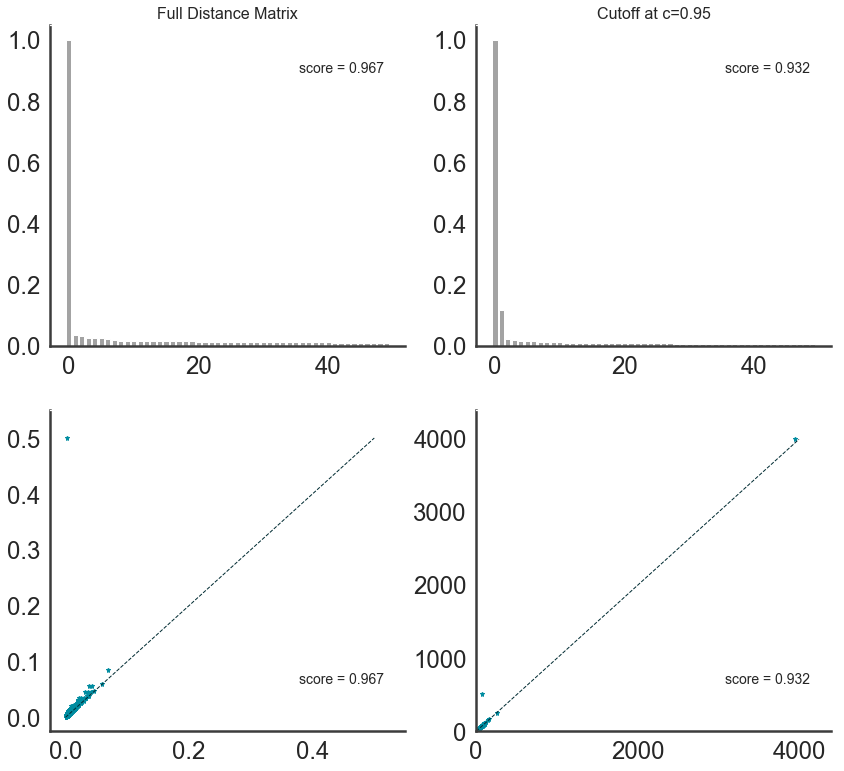

In [215]:
# persistence visuals
fig, axes = plt.subplots(2, 2, figsize=(14,13))

axes[0,0].set_title('Full Distance Matrix', fontsize=16)
axes[0,1].set_title(f'Cutoff at c={c:.2f}', fontsize=16)

plot_bar(dgm,   ax=axes[0,0], cap=50)
plot_bar(dgm_c, ax=axes[0,1], cap=50)
plot_dgm(dgm,   ax=axes[1,0])
plot_dgm(dgm_c, ax=axes[1,1])

axes[0,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=14);
axes[0,1].annotate(f'score = {dgm_c.GGS:.3f}', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=14);
axes[1,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.15), xycoords='axes fraction', fontsize=14);
axes[1,1].annotate(f'score = {dgm_c.GGS:.3f}', xy=(0.7, 0.15), xycoords='axes fraction', fontsize=14);

### Write summary - this might take a while ...
&nbsp;&nbsp;&nbsp;&nbsp;(~12h/34h on my computer)

In [62]:
write_summary(G, dgm=dgm_c, path=f'data/biological_networks/genes/gene_c{c:.2f}_summary.html')

### Save persistent visuals

In [216]:
plot_dgm(dgm, path=f'data/biological_networks/genes/gene_dgm.pdf', silence=True)
plot_bar(dgm, path=f'data/biological_networks/genes/gene_bar.pdf', silence=True, cap=30)

plot_dgm(dgm_c, path=f'data/biological_networks/genes/gene_c{c:.2f}_dgm.pdf', silence=True)
plot_bar(dgm_c, path=f'data/biological_networks/genes/gene_c{c:.2f}_bar.pdf', silence=True, cap=30)

## Soil

### MSE

In [34]:
# network preprocessing
d = 90

D = np.genfromtxt('data/biological_networks/soil/soil_gray_mse.txt')
A = np.where(np.abs(D)>d,0,1)
np.fill_diagonal(A,0)
G = nx.from_numpy_array(A)
# G = max(nx.connected_component_subgraphs(G), key=len)
# G = nx.convert_node_labels_to_integers(G)

for _, _, data in G.edges(data=True): data.pop('weight',None)
    
pos = nx.spring_layout(G, iterations=1000)

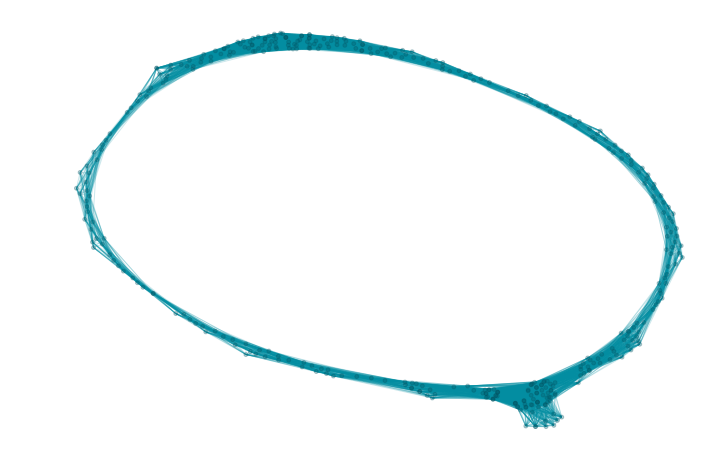

In [77]:
# network visuals
plot_nx(G, pos=pos)

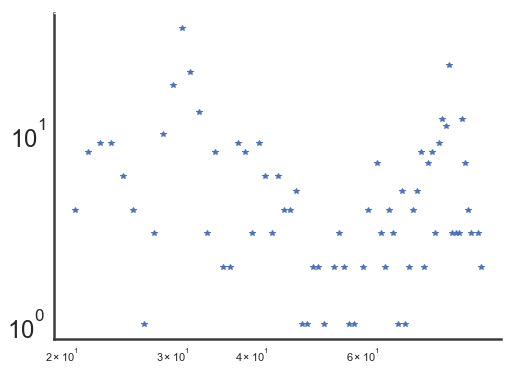

In [38]:
mode = 'loglog'

degree_sequence = sorted([d for n, d in G.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

eval(f"ax.{mode}(degs, cnts, '*', color=sblue)");

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

deg_fig.savefig(f'google_drive/soil/soil_mse_d{d:.2f}deg_{mode}.pdf', transparent=True)

In [80]:
# calclulating diagrams
dgm   = rng.ripser(D)

rng.induce_toa(G)
dgm_d = rng.diagram(G, toa='toa')

In [81]:
# add some vacuous points to the diagram to make the barplot look nicer
for i in range(10): dgm_d.append((0,0))

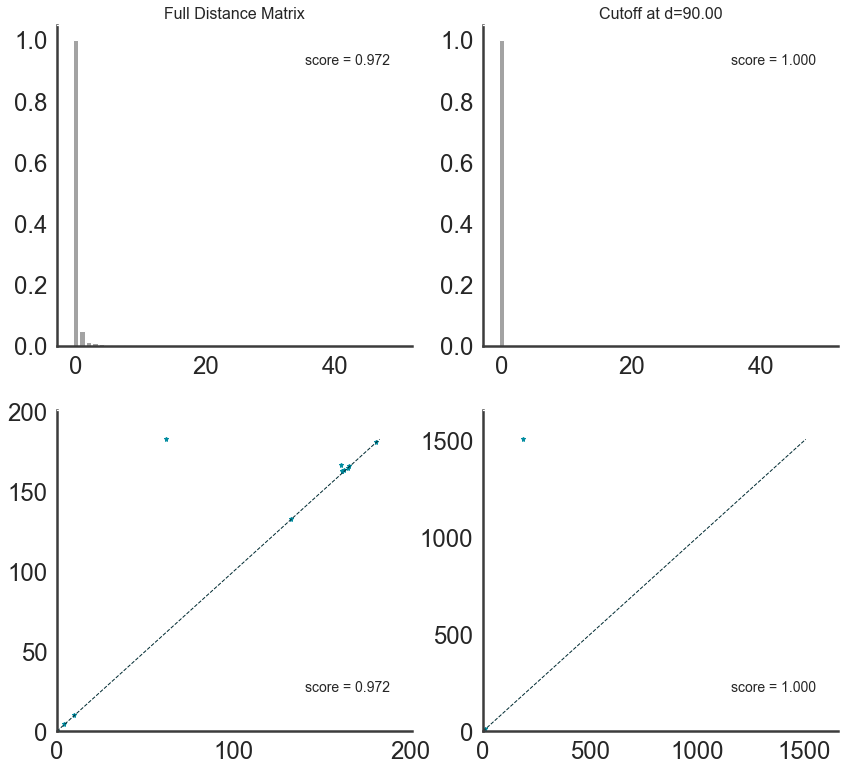

In [82]:
# persistence visuals
fig, axes = plt.subplots(2, 2, figsize=(14,13))

axes[0,0].set_title('Full Distance Matrix', fontsize=16)
axes[0,1].set_title(f'Cutoff at d={d:.2f}', fontsize=16)

plot_bar(dgm,   ax=axes[0,0], cap=50)
plot_bar(dgm_d, ax=axes[0,1], cap=50)
plot_dgm(dgm,   ax=axes[1,0])
plot_dgm(dgm_d, ax=axes[1,1])

axes[0,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=14);
axes[0,1].annotate(f'score = {dgm_d.GGS:.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=14);
axes[1,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=14);
axes[1,1].annotate(f'score = {dgm_d.GGS:.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=14);

### Save data

In [83]:
# save data
dgm.save(  f'data/biological_networks/soil/soil_mse_dgm.csv')
dgm_d.save(f'data/biological_networks/soil/soil_mse_d{d:.2f}_dgm.csv')

nx.write_edgelist(G, f'data/biological_networks/soil/soil_mse_d{d:.2f}_weightlist.csv')
nx.write_edgelist(G, f'data/biological_networks/soil/soil_mse_d{d:.2f}_edgelist.csv', data=False)

write_summary(G, dgm_d, path=f'data/biological_networks/soil/soil_mse_d{d:.2f}_summary.html')

In [84]:
# save visuals
plot_dgm(dgm, path=f'data/biological_networks/soil/soil_mse_dgm.pdf', silence=True)
plot_bar(dgm, path=f'data/biological_networks/soil/soil_mse_bar.pdf', silence=True, cap=30)

plot_dgm(dgm_d, path=f'data/biological_networks/soil/soil_mse_d{d:.2f}_dgm.pdf', silence=True)
plot_bar(dgm_d, path=f'data/biological_networks/soil/soil_mse_d{d:.2f}_bar.pdf', silence=True, cap=30)
plot_nx(G,      path=f'data/biological_networks/soil/soil_mse_d{d:.2f}_nx.pdf',  silence=True, pos=pos)

deg_fig.savefig(f'data/biological_networks/soil/soil_mse_d{d:.2f}_deg.pdf', transparent=True)

### SSIM

In [161]:
# network preprocessing
c = 0.95

C = np.genfromtxt('data/biological_networks/soil/soil_gray_ssim.txt')
D = 1-np.abs(C)
A = np.where(np.abs(C)>c,1,0)
np.fill_diagonal(A,0)
G = nx.from_numpy_array(A)
# G = max(nx.connected_component_subgraphs(G), key=len)
# G = nx.convert_node_labels_to_integers(G)

for _, _, data in G.edges(data=True): data.pop('weight',None)
    
pos = nx.spring_layout(G)

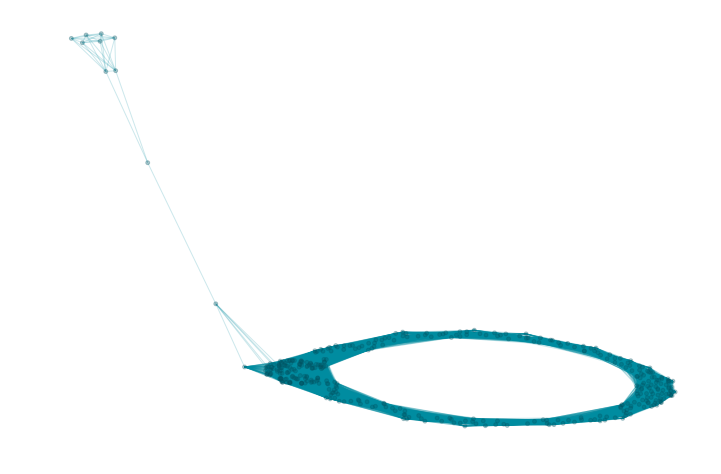

In [162]:
# network visuals
plot_nx(G, pos=pos)

In [163]:
# calclulating diagrams
dgm   = rng.ripser(D)

rng.induce_toa(G)
dgm_c = rng.diagram(G, toa='toa')

In [167]:
# add some vacuous points to the diagram to make the barplot look nicer
for i in range(10): dgm.append((0,0))
for i in range(10): dgm_c.append((0,0))

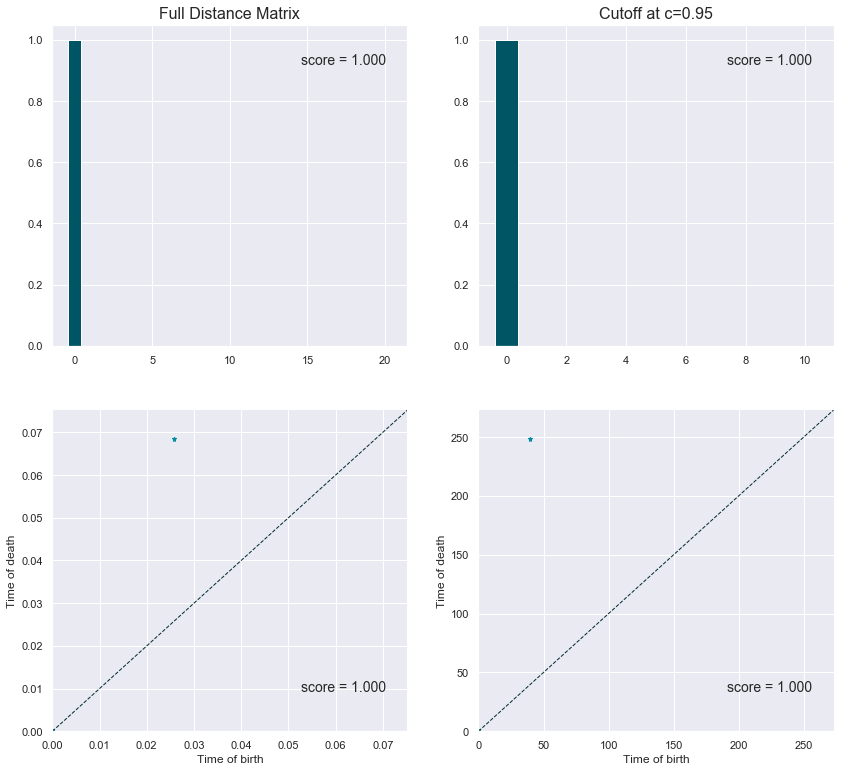

In [168]:
# persistence visuals
fig, axes = plt.subplots(2, 2, figsize=(14,13))

axes[0,0].set_title('Full Distance Matrix', fontsize=16)
axes[0,1].set_title(f'Cutoff at c={c:.2f}', fontsize=16)

plot_bar(dgm,   ax=axes[0,0], cap=50)
plot_bar(dgm_c, ax=axes[0,1], cap=50)
plot_dgm(dgm,   ax=axes[1,0])
plot_dgm(dgm_c, ax=axes[1,1])

axes[0,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=14);
axes[0,1].annotate(f'score = {dgm_c.GGS:.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=14);
axes[1,0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=14);
axes[1,1].annotate(f'score = {dgm_c.GGS:.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=14);

### Save Data

In [171]:
# save data
dgm.save(  f'data/biological_networks/soil/soil_ssim_dgm.csv')
dgm_c.save(f'data/biological_networks/soil/soil_ssim_c{c:.2f}_dgm.csv')

nx.write_edgelist(G, f'data/biological_networks/soil/soil_ssim_c{c:.2f}_weightlist.csv')
nx.write_edgelist(G, f'data/biological_networks/soil/soil_ssim_c{c:.2f}_edgelist.csv', data=False)

write_summary(G, dgm_c, path=f'data/biological_networks/soil/soil_ssim_c{c:.2f}_summary.html')

In [172]:
# save visuals
plot_dgm(dgm, path=f'data/biological_networks/soil/soil_ssim_dgm.pdf', silence=True)
plot_bar(dgm, path=f'data/biological_networks/soil/soil_ssim_bar.pdf', silence=True, cap=50)

plot_dgm(dgm_c, path=f'data/biological_networks/soil/soil_ssim_c{c:.2f}_dgm.pdf', silence=True)
plot_bar(dgm_c, path=f'data/biological_networks/soil/soil_ssim_c{c:.2f}_bar.pdf', silence=True, cap=50)
plot_nx(G,      path=f'data/biological_networks/soil/soil_ssim_c{c:.2f}_nx.pdf',  silence=True, pos=pos)

## Interferons 

In [39]:
# network preprocessing
G = nx.read_edgelist('data/biological_networks/IFNs/IFN_edgelist.csv')
G = G.to_undirected()
G = max(nx.connected_component_subgraphs(G), key=len)
G = nx.convert_node_labels_to_integers(G)

pos = nx.spring_layout(G, iterations=1000)

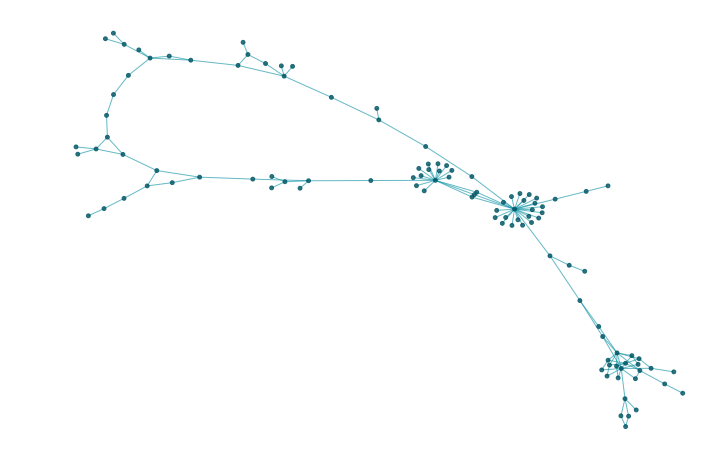

In [40]:
# network visuals
# pos = comb(pos) # moves sticky-out edges closer to the center
plot_nx(G, pos=pos, node_alpha=0.8, edge_alpha=0.6)

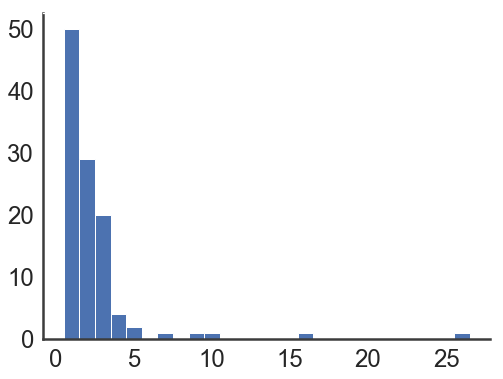

In [44]:
mode = 'bar'

degree_sequence = sorted([d for n, d in G.degree()])
degreeCount = Counter(degree_sequence)
degs, cnts = zip(*degreeCount.items())

deg_fig, ax = plt.subplots(figsize=(8,6))
deg_fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

eval(f"ax.{mode}(degs, cnts, width=1, color=sblue)");

ax.tick_params(axis='both', which='major', labelsize=24)

ax.spines['left'].set_linewidth(2.5)
ax.spines['left'].set_color(sblack2)

ax.spines['bottom'].set_linewidth(2.5)
ax.spines['bottom'].set_color(sblack2)

deg_fig.savefig(f'google_drive/IFNs/IFN_deg_{mode}.pdf', transparent=True)

In [88]:
# calclulating diagrams
rng.induce_toa(G)
dgm = rng.diagram(G, toa='toa')

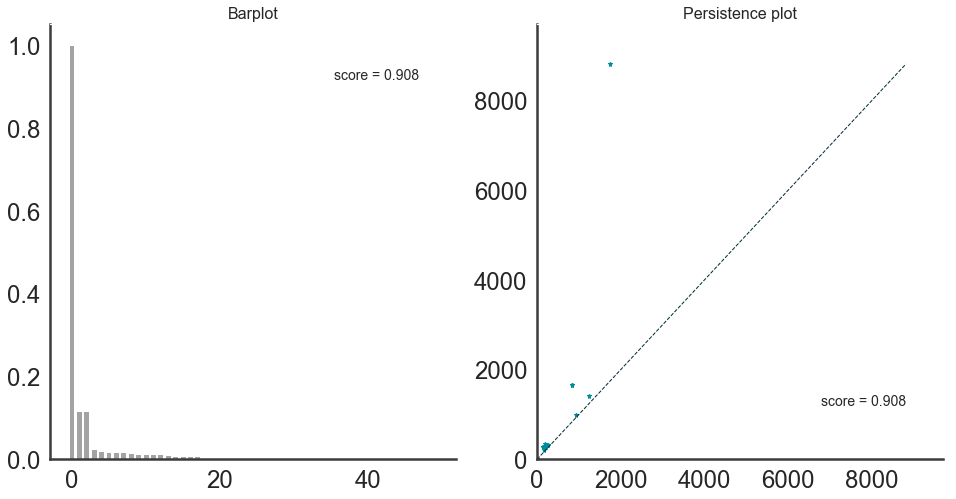

In [89]:
# persistence visuals
fig, axes = plt.subplots(1,2, figsize=(16,8))

axes[0].set_title('Barplot', fontsize=16)
axes[1].set_title('Persistence plot', fontsize=16)

plot_bar(dgm, ax=axes[0], cap=50)
plot_dgm(dgm, ax=axes[1])

axes[0].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.875), xycoords='axes fraction', fontsize=14);
axes[1].annotate(f'score = {dgm.GGS  :.3f}', xy=(0.7, 0.125), xycoords='axes fraction', fontsize=14);

### Save data

In [90]:
# save data
dgm.save(  f'data/biological_networks/IFNs/IFN_dgm.csv')
nx.write_edgelist(G, f'data/biological_networks/IFNs/IFN_weightlist.csv')
write_summary(G, dgm, path=f'data/biological_networks/IFNs/IFN_summary.html')

In [91]:
# save visuals
plot_dgm(dgm, path=f'data/biological_networks/IFNs/IFN_dgm.pdf', silence=True)
plot_bar(dgm, path=f'data/biological_networks/IFNs/IFN_bar.pdf', silence=True, cap=30)
plot_nx(G,    path=f'data/biological_networks/IFNs/IFN_nx.pdf',  silence=True, 
        pos=pos, node_alpha=0.8, edge_alpha=0.6)

deg_fig.savefig(f'data/biological_networks/IFNs/IFN_deg.pdf', transparent=True)